# Goal

With the development of the LIG ice-sheet model emulator in **construct_lig_emulator.ipynb** and the latin-hypercube design in **lhc_design.ipynb**, we are equipped to begin sampling from the emulator. The purpose of sampling from the LIG emulator is to inform our sampling of the RCP8.5 emulator, and for that we need LIG observational constraints. In this code we develop posterior likelihoods of CREVLIQ and CLIFVMAX (the ice-sheet model parameters), illustrating how specific and more generalized assumptions about the shape and magnitude of the LIG observational record influences those likelihoods.

The specific LIG Distribution constraints explored are:

- Unconstrained: Distribution with uniform equal weights across all parameters
- D20-U: DeConto et al. (2020) Uniform distribution
- D20-N: DeConto et al. (2020) distribution Assumed Gaussian
- E19-U: Edwards et al. (2020) Uniform distribution based on DeConto and Pollard (2016)
- K09-125ka: Kopp et al. (2009) GP Distribution Time Slice at 125ka
- K09-Max-3kyrSmooth: Kopp et al. (2009) GP Distribution Maximums of Samples (smoothed over 3kyr)

We also explore the effects of two sets of hypothetical LIG constraints:

- High and low distributions: Assuming LIG AIS>6 m and LIG AIS<3.5 m, respectively
- Narrower D20-U: Sensitivity to reduced uncertainties in LIG estimates

And the specific likelihoods from all of these constraints are saved out to use as weights for the RCP emulator sampling in **sample_rcp_emulator.ipynb**.

# Setup

In [1]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

In [2]:
# define the colormap
plt.set_cmap('viridis')
# define the save path for our plots
save_path='./figures/'
# import a series of colors for the prior vs. constraints plot
from lig_utilities import call_scm_cmap, uniform_cmap_slices
cmap=call_scm_cmap('roma')
cols=uniform_cmap_slices(cmap,5,col_range=[0,1.0])[::-1]
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package to load the GP model and sample
import gpflow
from lig_utilities import normalize, denormalize
# load the modules to compute the statistics
from lig_utilities import posterior_densities, cookbook_smoother
# import tensorflow so we can restore the trained model
import tensorflow as tf

# Data and Model

We load in the latin-hypercube (LHC) design to our sampling, and restore the trained GPflow model from which to sample. In each of the LIG constraint scenarios defined below, we load/access the data for that simulation individually in that section.

### Load the LHC Design

In [4]:
# load the design from pickle
lhd=pickle.load(open( "./models/lig_lhc_design_10000.pk1", "rb" ) )

### Load the Training Data (to reconstruct the GP model)

In [5]:
# load the training data from the pickle and print its keys
train_dat=pickle.load(open( "./models/lig_model_traindata.pk1", "rb" ) )
train_dat.keys()

dict_keys(['Y_train', 'crevliq', 'clifvmax', 'X_train', 'kernel_code', 'model_name'])

### Restore the Trained GP model

In [6]:
# reconstruct the GP model
with gpflow.defer_build():
    
    # define the kernel
    k = eval(train_dat['kernel_code'])

    # create the model
    m = gpflow.models.GPR(train_dat['X_train'], \
        train_dat['Y_train'].reshape(np.size(train_dat['Y_train']),1), kern=k, name=train_dat['model_name'])
    
    # Fix the nugget term
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_graph = m.enquire_graph()
tf_session = m.enquire_session()
m.compile( tf_session )

# create the saver object and load the archived model object
saver = tf.train.Saver()
save_path = saver.restore(tf_session, "./models/lig_model.ckpt")
print("Model loaded from path: %s" % save_path)

# anchor the model to restore optimized hyperparameters
m.anchor(tf_session)

INFO:tensorflow:Restoring parameters from ./models/lig_model.ckpt


INFO:tensorflow:Restoring parameters from ./models/lig_model.ckpt


Model loaded from path: None


In [7]:
# uncomment to verify the hyperparameters are correctly restored
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_model/kern/lengthscales,Parameter,None,+ve,True,(),True,45.69875317037066
lig_model/kern/variance,Parameter,None,+ve,True,(),True,17.048461576529924
lig_model/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


# Sampling

With the LHC design and data loaded in, and the GP model restored, we now sample from the model across a set of different LIG constraints. In particular, the samples are constrained by different definitions, assumptions, and interpretations of LIG Antarctic contributions to sea level rise.

We find posterior (likelihoods)of the samples over the CREVLIQ/CLIFVMAX parameter space (and also emulated sea level contributions during the LIG), and then use these likelihoods to weight our samples from the RCP8.5 emulator in **sample_rcp_emulator.ipynb**.

## Priors

### Marginal Prior Distributions: Parameter Space

Let's begin by visualizing the marginal (non-joint) prior distributions for CREVLIQ and CLIFVMAX (over their original range, 0--195 and 0--13, respectively) before any constraints are applied.

In [8]:
# define the prior distributions for the parameters
# training data
clifvmax_prior=denormalize(train_dat['X_train'][:,1],np.max(train_dat['clifvmax']),np.min(train_dat['clifvmax']))
crevliq_prior=denormalize(train_dat['X_train'][:,0],np.max(train_dat['crevliq']),np.min(train_dat['crevliq']))
# LHC design
clifvmax_prior_lhc=denormalize(lhd[:,1],np.max(train_dat['clifvmax']),np.min(train_dat['clifvmax']))
crevliq_prior_lhc=denormalize(lhd[:,0],np.max(train_dat['crevliq']),np.min(train_dat['crevliq']))

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


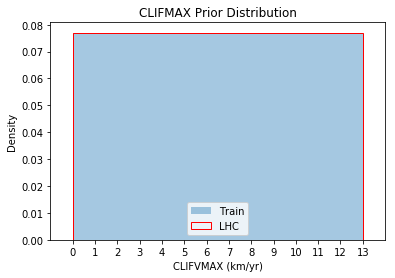

In [9]:
# plot the normalize distribution of CLIFVMAX
prior_clifvmax_fig=plt.figure()
plt.hist(clifvmax_prior,bins=14,normed=True,histtype='stepfilled',alpha=0.4,label='Train')
plt.hist(clifvmax_prior_lhc,bins=14,normed=True,color='r',histtype='step',label='LHC')
plt.title('CLIFMAX Prior Distribution')
plt.ylabel('Density')
plt.xlabel('CLIFVMAX (km/yr)')
plt.xlim([-1,14])
plt.xticks(train_dat['clifvmax'])
plt.legend(loc='lower center')
plt.show()

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


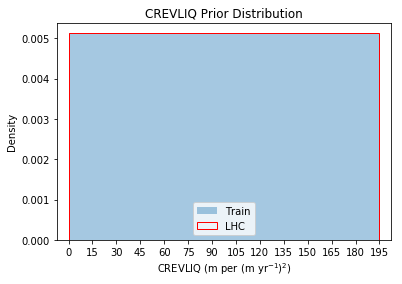

In [10]:
# plot the normalize distribution of CREVLIQ
prior_clifvmax_fig=plt.figure()
plt.hist(crevliq_prior,bins=14,normed=True,histtype='stepfilled',alpha=0.4,label='Train')
plt.hist(crevliq_prior_lhc,bins=14,normed=True,color='r',histtype='step',label='LHC')
plt.title('CREVLIQ Prior Distribution')
plt.ylabel('Density')
plt.xlabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.xlim([-7.5,202.5])
plt.xticks(train_dat['crevliq'])
plt.legend(loc='lower center')
plt.show()

It's clear from the original ensemble design (and illustrated from these distributions) that the marginal prior distributions for CREVLIQ and CLIFVMAX are uniform in the training data the LHC design.

### Equally-Likely Distributions over the Parameter Space

We can also plot the prior joint distributions for CREVLIQ/CLIFVMAX, which are by defintion of the construction equally likely. Start by denormalizing the LHC design.

In [11]:
# denormalize the training grid
denorm_prior_x=denormalize(lhd[:,1],np.max(clifvmax_prior),np.min(clifvmax_prior))
denorm_prior_y=denormalize(lhd[:,0],np.max(crevliq_prior),np.min(crevliq_prior))
ns1,ns2 = len(lhd[:,1]),len(lhd[:,0])
denormed_lhd=np.asarray([denorm_prior_y,denorm_prior_x]).T

 For the 10,000 samples drawn from the LHC design, an equal (normalized) likelihood for each CREVLIQ/CLIFVMAX value is simple 1/10,000:


In [12]:
equal_density=np.empty((ns1,1),dtype='float')
equal_density[:]=1/10000

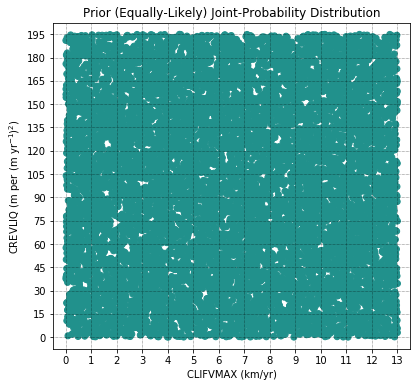

In [13]:
# plot the prior joint-distributions of CREVLIQ/CLIFMVMAX
cc_equallikelihood_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=np.squeeze(equal_density),edgecolors='face')
cb=plt.colorbar()
cb.remove()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title('Prior (Equally-Likely) Joint-Probability Distribution')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

### Unconstrained Distribution: LIG Sea Level Contributions sampled with equal likelihoods

Use the equally-likely probabilities of CREVLIQ/CLIFVMAX to weight LHC samples from the GP model, then plot the unconstrained distribution of Antarctic contributions to sea level during the LIG.

In [14]:
# import the scipy packages needed to define distrubutions
from scipy.stats import uniform, norm

In [15]:
# get the prior distribution from the training data
prior_train_Y=train_dat['Y_train']

# get model outputs along the LHC design
prior_mean,prior_var=m.predict_y(lhd)

# define the prior pdf from the GP emulator, note that its properties (e.g. "pdf")
# have length = number of samples in the LHC design (i.e. or the same as in "prior_mean"/"prior_var")
prior_norm=norm(loc=prior_mean,scale=np.sqrt(prior_var))

We compute the density of the uconstrained distribution by integrating over the emulator densities as sampled by the LHC design.

In [16]:
# create the bins to perform our density estimate
integration_step=1e-03
min_val,max_val=1.5,7.5
step_locs=np.arange(min_val,max_val+integration_step,step=integration_step)

# estimate the unconstrained PDF from the LHC samples, using a likelihood distribution where all LIG values are equally likely
prior_dist=posterior_densities(step_locs,prior_norm,0)

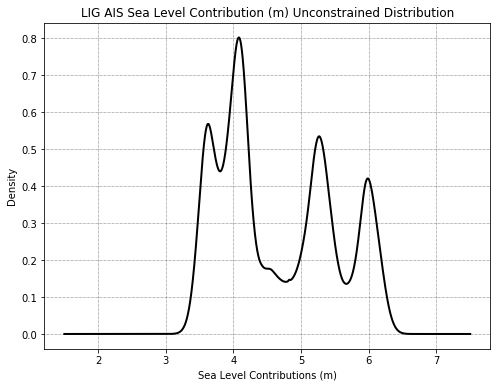

In [17]:
# plot the result for the normalized posterior sea levels
prior_lig_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2)
plt.title('LIG AIS Sea Level Contribution (m) Unconstrained Distribution')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.show()

## D20-U: DeConto et al. (2020) Uniform distribution

Several versions of the constraint considered here has been used in ice-sheet modeling/callibration literature, where the ice-sheet model runs are passed through a uniform window and the runs which fall outside the window are discarded. This is akin to a tail-trimming procedure, and by nature is liable to assign zero probability to the tails of your projection probabilities.

Because of its common use, here we treat this as a baseline likelihood to find the posterior distributions. Our Bayesian approach acts like a tail-trimming approach, but instead of having a binary score, we take advantage of the emulator's uncertainty to ascribe probabilities for each sample based on its likelihood of falling within the uniform D20-U window. These probabilities are then used to weight the posterior of the LIG and RCP8.5 sea-level equivalent distributions of AIS mass loss.

---

The uniform constraint we apply here was used in DeConto et al. (2020) with the window technique described above. The uniform distribution for the LIG at the maximum extent of AIS retreat (~125-128ka) is $U(3.1, 6.1)$ (in meters).

For a given set of CREVLIQ/CLIFVMAX (with the sets sampled via our LHC design), there is an emulated sea-level contribution from the AIS that is given by a gaussian distribution (with mean and variance found with the GP model), as shown in the unconstrained emulated distributions above.

In [18]:
# define the LIG uniform distribution from D20
lig_range=[3.1,6.1]
deconto19_uniform_dist=uniform(loc=lig_range[0], scale=lig_range[1]-lig_range[0])

The module "posterior_densities" is used to estimate the posterior distribution of AIS sea-level contributions given  sample likelihoods (such as the uniform distribution of DeConto et al. 2020 considered here). We may therefore apply:

In [19]:
# find the posterior
deconto19_uniform=posterior_densities(step_locs,prior_norm,deconto19_uniform_dist)

And now we plot the resulting posterior distribution compared with the unconstrained distribution.

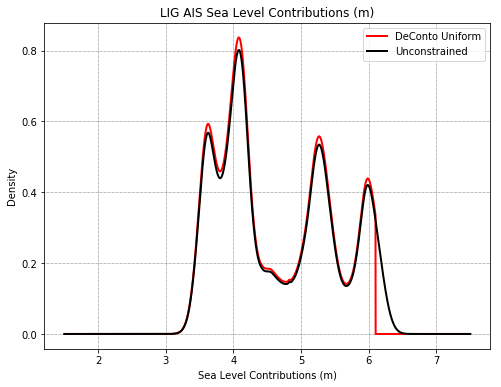

In [20]:
# plot the result for the normalized posterior sea levels
D20_U_ligpost_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,deconto19_uniform['posterior'],'r',lw=2,label='DeConto Uniform')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

Notice that the upper tail of the prior distribution has been trimmed in the posterior at 6.1 meters, where the D20 uniform distribution disallows any density to pass through the window.

We can also plot the likelihoods associated with each individual sample (which have a fixed CREVLIQ/CLIFVMAX set). For a given sample's distribution (given by the mean and variance of the emulator at the parameter value of the individual sample in the LHC design), we assessed the density of that distribution which passes through the LIG likelihood (i.e. here, the Uniform distribution for the LIG defined in DeConto et al. 2020). We can plot these over the parameter and assess which regions of the parameter space are consistent with this particular interpretation of the likely values for the LIG AIS contributions to sea level rise.

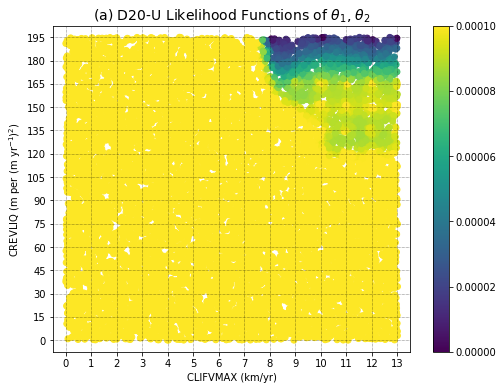

In [21]:
# define the levels for plotting colors on scatter plots
scatter_levels=[0,1e-4]

# plot the result for the normalized posterior sea levels
cc_D20_U_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=deconto19_uniform['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'(a) D20-U Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

In [22]:
# save the plot out
save_path='./figures/'
savename='FigS5a.pdf'
cc_D20_U_fig.savefig(save_path+savename)

We repeat the above analyses with each of the following distributions...

## D20-N: DeConto et al. (2020) distribution Assumed Gaussian

The distance between the mean of the D20-U distribution and it's edge (0.75 m) may be treated as the variance in a Gaussian adaptation of the D20-U distribution. Assuming it's normal, the mean is given by the mean of D20-U, and the variance is as above, we finding the associated parameter weightings.

In [23]:
# find the mean and standard deviation
deconto_gauss_mean=np.mean(lig_range)
deconto_gauss_std=np.sqrt(0.5*(lig_range[1]-np.mean(lig_range)))
deconto_gauss_dist=norm(loc=deconto_gauss_mean,scale=deconto_gauss_std)

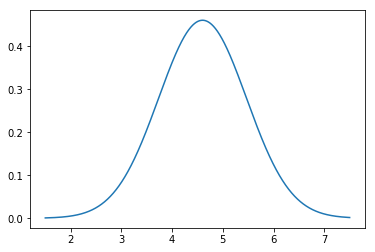

In [24]:
plt.plot(step_locs,deconto_gauss_dist.pdf(step_locs))

In [25]:
# find the posterior
deconto19_gaussian=posterior_densities(step_locs,prior_norm,deconto_gauss_dist)

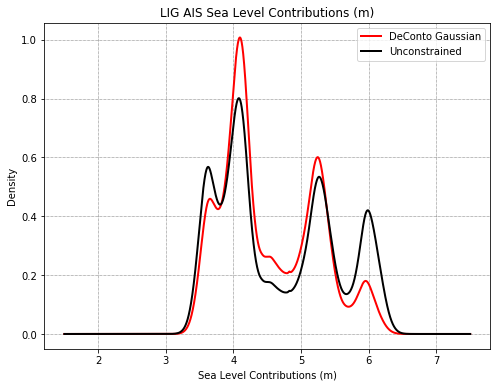

In [26]:
# plot the result for the normalized posterior sea levels
D20_N_ligpost_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,deconto19_gaussian['posterior'],'r',lw=2,label='DeConto Gaussian')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

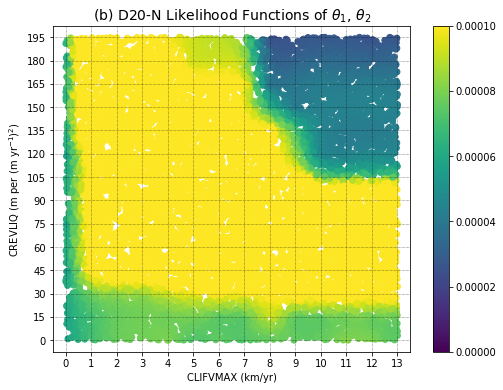

In [27]:
# plot the result for the normalized posterior sea levels
cc_D20_N_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=deconto19_gaussian['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'(b) D20-N Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

In [28]:
# save the plot out
savename='FigS5b.pdf'
cc_D20_N_fig.savefig(save_path+savename)

## E19-U: Edwards et al. (2019) Uniform distribution

Edwards et al. (2019) assumes a LIG range of 3.5–7.4 meters, with equal/uniform weighting following DeConto and Pollard (2016). We can therefore test/compare an accordant uniform distribution for the LIG, $U(3.5, 7.4)$ (in meters), to see the implications of these constraints for our posteriors.

In [29]:
# define the LIG uniform distribution, as per Edwards et al. (2019)
edwards19_range=[3.5,7.4]
edwards19_dist=uniform(loc=edwards19_range[0], scale=edwards19_range[1]-edwards19_range[0])

# find the posterior
edwards19_uniform=posterior_densities(step_locs,prior_norm,edwards19_dist)

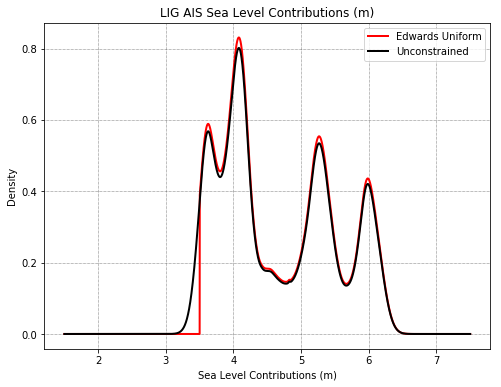

In [30]:
# plot the result for the normalized posterior sea levels
e19_U_ligpost_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,edwards19_uniform['posterior'],'r',lw=2,label='Edwards Uniform')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

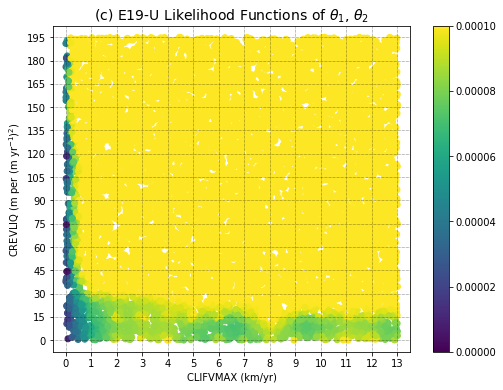

In [31]:
# plot the result for the normalized posterior sea levels
cc_e19_U_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=edwards19_uniform['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'(c) E19-U Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

In [32]:
# save the plot out
savename='FigS5c.pdf'
cc_e19_U_fig.savefig(save_path+savename)

## High/low LIG distributions

These are two hypothetical constraints of <3.5 m (LOW) or >6m (HIGH) that are used to show how changes in our understanding of LIG AIS sea-level contributions would affect sea-level rise projections by the emulator.

In [33]:
# define the high and low range
high_range=[6,7.5]
low_range=[1.5,3.5]
# get the uniform distributions
high_uniform_dist=uniform(loc=high_range[0], scale=high_range[1]-high_range[0])
low_uniform_dist=uniform(loc=low_range[0], scale=low_range[1]-low_range[0])
# find the posteriors
high_uniform=posterior_densities(step_locs,prior_norm,high_uniform_dist)
low_uniform=posterior_densities(step_locs,prior_norm,low_uniform_dist)

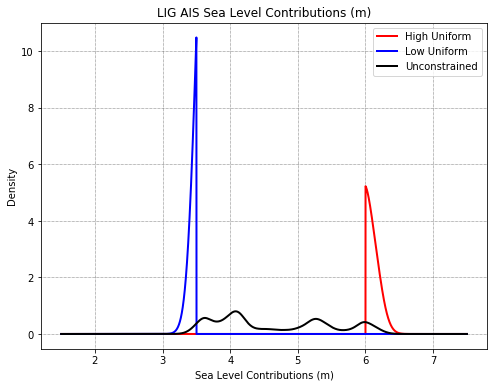

In [34]:
# plot the result for the normalized posterior sea levels
highlow_ligpost_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,high_uniform['posterior'],'r',lw=2,label='High Uniform')
plt.plot(step_locs,low_uniform['posterior'],'b',lw=2,label='Low Uniform')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.xlim()
plt.show()

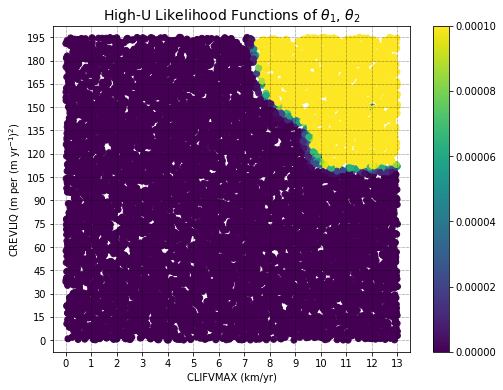

In [35]:
# plot the result for the normalized posterior sea levels
cc_high_U_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=high_uniform['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'High-U Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

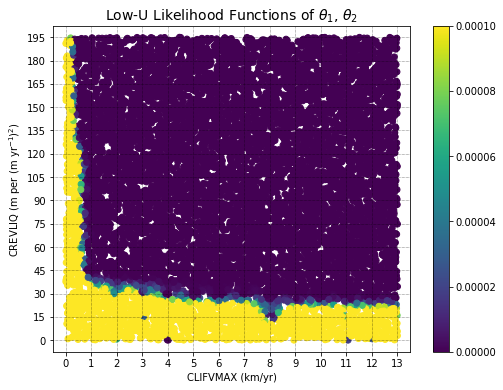

In [36]:
# plot the result for the normalized posterior sea levels
cc_low_U_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=low_uniform['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'Low-U Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

The above likelihoods will be saved and used to weight high/low samples of the RCP8.5 emulator.

## Narrower D20-U: Fixed Central Value, Varying Width

These are set of hypothetical constraints showing the sensitivity of our results to reduced uncertainties in the LIG AIS mass loss. Starting with the D20-U distribution, we gradually decrease the range of the uniform constraint by 10%, 25%, 50%, 75%, and 90% and find the associated parameter sample weights.

In [37]:
# choose the central value of the D20 distribution
central_val=(3.1+6.1)/2
base_range=3
# choose the increasing ranges
increased_range=np.asarray([base_range*0.10, base_range*0.25, base_range*0.50, base_range*0.75, base_range*0.90, base_range*1.0])
print(increased_range)
print(central_val-increased_range/2)
print(central_val+increased_range/2)

# create the uniform distributions
range90_dist=uniform(loc=central_val-increased_range[0]/2, scale=increased_range[0])
range75_dist=uniform(loc=central_val-increased_range[1]/2, scale=increased_range[1])
range50_dist=uniform(loc=central_val-increased_range[2]/2, scale=increased_range[2])
range25_dist=uniform(loc=central_val-increased_range[3]/2, scale=increased_range[3])
range10_dist=uniform(loc=central_val-increased_range[4]/2, scale=increased_range[4])

# find the posteriors
range90_uniform=posterior_densities(step_locs,prior_norm,range90_dist)
range75_uniform=posterior_densities(step_locs,prior_norm,range75_dist)
range50_uniform=posterior_densities(step_locs,prior_norm,range50_dist)
range25_uniform=posterior_densities(step_locs,prior_norm,range25_dist)
range10_uniform=posterior_densities(step_locs,prior_norm,range10_dist)

[ 0.3   0.75  1.5   2.25  2.7   3.  ]
[ 4.45   4.225  3.85   3.475  3.25   3.1  ]
[ 4.75   4.975  5.35   5.725  5.95   6.1  ]


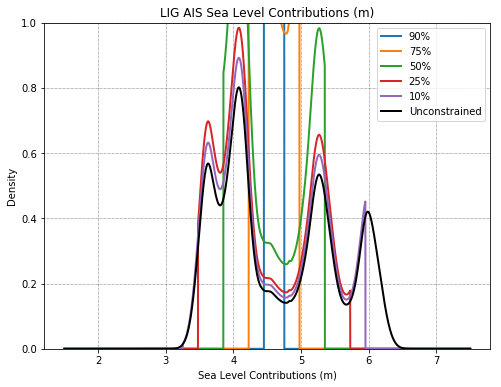

In [38]:
# plot the result for the normalized posterior sea levels
slidingcentral_ligpost_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,range90_uniform['posterior'],lw=2,label='90%')
plt.plot(step_locs,range75_uniform['posterior'],lw=2,label='75%')
plt.plot(step_locs,range50_uniform['posterior'],lw=2,label='50%')
plt.plot(step_locs,range25_uniform['posterior'],lw=2,label='25%')
plt.plot(step_locs,range10_uniform['posterior'],lw=2,label='10%')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlim()
plt.show()

## K09-125ka: Time slice at 125ka from Kopp et al. (2009)

To compare with a completely empirical record with much uncertainty, we use the Kopp et al. (2009; K09) compiled probability distributions of AIS contributions to sea-level rise. Posterior probability distributions of AIS LIG sea levels were estimated over time by K09 with guassian process regression, by conditioning on local sea-level and age measurements.

To generate a simple constraint distribution consistent with the LIG ensemble, we will take a time slice at 125 ka (5,000 years after the initial time period of our LIG forcing), and use the distribution there to find the probabilities of each parameter set, which become the likelihoods in our Bayesian calibration.

In [39]:
# load in the data from Kopp et al. (2009)
import scipy.io as sio
k09_dat=sio.loadmat('./data/K09_data.mat')

In [40]:
# find the index where the time==125ka
ind125=np.where(k09_dat['t']==125.)[0]

In [41]:
# Find samples from the K09 GP
n_gps=k09_dat['mu'].shape[1]
ntime=k09_dat['mu'].shape[0]
# sample from the data, with the number of samples chosen by the user
nsamps=1
k09_samps=np.empty((ntime,n_gps,nsamps),dtype='float')
for s in range(n_gps):
    k09_samps[:,s,:]=np.random.multivariate_normal(np.squeeze(k09_dat['mu'][:,s]),np.squeeze(k09_dat['V'][:,:,s]),size=nsamps).T
    
# each sample is independant, so we can ravel
k09_samps_125=np.squeeze(k09_samps[ind125,:,:]).ravel()

# reduce the samples by the K09 baseline level (in meters) to set them as anomalies relative to 1950
baseline_level=63
k09_samps_125=baseline_level-k09_samps_125

In [42]:
# fit an empirical distribution using KDE
k09_125_dist=scipy.stats.gaussian_kde(k09_samps_125)

# find the posterior
k09_125_posterior=posterior_densities(step_locs,prior_norm,k09_125_dist)

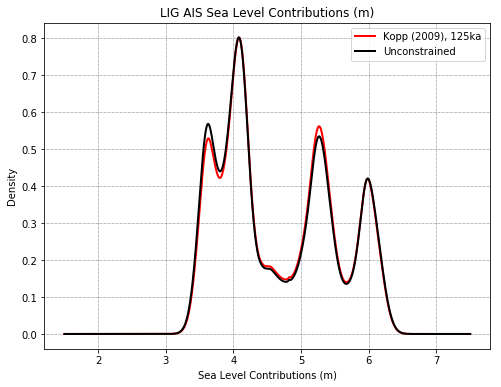

In [43]:
# plot the result for the normalized posterior sea levels
k09_GP_ligpost_125_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,k09_125_posterior['posterior'],'r',lw=2,label='Kopp (2009), 125ka')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

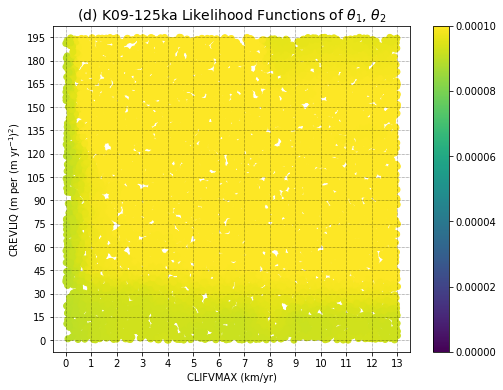

In [44]:
# plot the result for the normalized posterior sea levels
cc_k09_GP_125_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=k09_125_posterior['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'(d) K09-125ka Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

In [45]:
# save the plot out
savename='FigS5d.pdf'
cc_k09_GP_125_fig.savefig(save_path+savename)

## K09: Maximum of Each Sample (129-114ka)

Extending the above analyses of K09 to more closely mirror our ice-sheet model simulations, we generate 2,500 samples from the K09 GP model over time, and then smooth each sample with a 3 kyr-window boxcar filter. From these distributions we select the maximum value at any point in time, and form a distribution of these maximum values to act as the LIG constraint.

For completeness and comparison, we also smooth over 5kyr and 1kyr windows.

In [46]:
# truncate the timeseries between 114ka and 129ka following K09, Fig. 4-5
trunc_inds=np.squeeze((k09_dat['t']>=114) & (k09_dat['t']<=129))
k09_dat['t'][trunc_inds]

array([[129],
       [128],
       [127],
       [126],
       [125],
       [124],
       [123],
       [122],
       [121],
       [120],
       [119],
       [118],
       [117],
       [116],
       [115],
       [114]], dtype=uint8)

In [47]:
# smooth the samples over 1kya, 3kya, and 5kya windows (note that 1kyr is not smoothed at all)
trunc_samples=baseline_level-k09_samps[trunc_inds,:,:]
smooth_windows=[1,3,5]
smoothed_samples=np.empty((len(smooth_windows),np.sum(trunc_inds),n_gps*k09_samps.shape[2]),dtype='float')
for s in range(len(smooth_windows)):
    window=smooth_windows[s]
    for g in range(n_gps):
        for i in range(nsamps):
            tind=int((window-1)/2)
            #print(tind)
            sampind=(g*nsamps)+i
            #print(sampind)
            if s==0:
                smoothed_samples[s,:,sampind]=np.squeeze(trunc_samples[:,g,i])
            else:
                smoothed_samples[s,:,sampind]=cookbook_smoother(np.squeeze(trunc_samples[:,g,i]),window_len=window,window='flat')[tind:-tind]

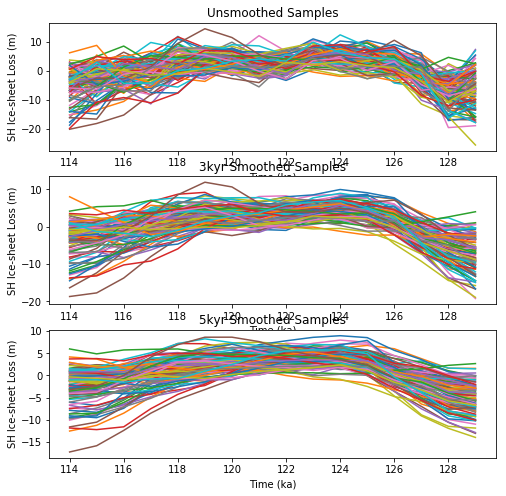

In [48]:
# plot the smoothed timeseries
plt.figure(figsize=(8,8))

plt.subplot(3, 1, 1)
plt.plot(k09_dat['t'][trunc_inds],smoothed_samples[0,:,0:100])
plt.ylabel('SH Ice-sheet Loss (m)')
plt.xlabel('Time (ka)')
plt.title('Unsmoothed Samples')

plt.subplot(3, 1, 2)
plt.plot(k09_dat['t'][trunc_inds],smoothed_samples[1,:,0:100])
plt.ylabel('SH Ice-sheet Loss (m)')
plt.xlabel('Time (ka)')
plt.title('3kyr Smoothed Samples')


plt.subplot(3, 1, 3)
plt.plot(k09_dat['t'][trunc_inds],smoothed_samples[2,:,0:100])
plt.ylabel('SH Ice-sheet Loss (m)')
plt.xlabel('Time (ka)')
plt.title('5kyr Smoothed Samples')

plt.show()

In [49]:
# find the maximum of each sample and form a distribution
k09_unsmoothed_samps_max=np.max(np.squeeze(smoothed_samples[0,:,:]),axis=0)
k09_smoothed3kyr_samps_max=np.max(np.squeeze(smoothed_samples[1,:,:]),axis=0)
k09_smoothed5kyr_samps_max=np.max(np.squeeze(smoothed_samples[2,:,:]),axis=0)

In [50]:
locmax=np.argmax(np.squeeze(smoothed_samples[1,:,:]),axis=0)

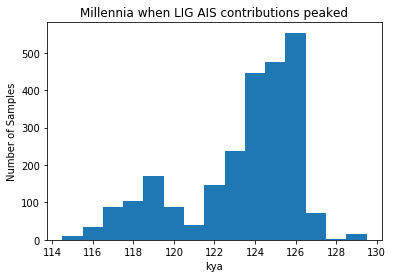

In [51]:
plt.figure()
plt.hist(k09_dat['t'][trunc_inds][locmax],bins=np.linspace(115-0.5,129+0.5,129-115+2))
plt.xlabel('kya')
plt.ylabel('Number of Samples')
plt.title('Millennia when LIG AIS contributions peaked')
plt.show()

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


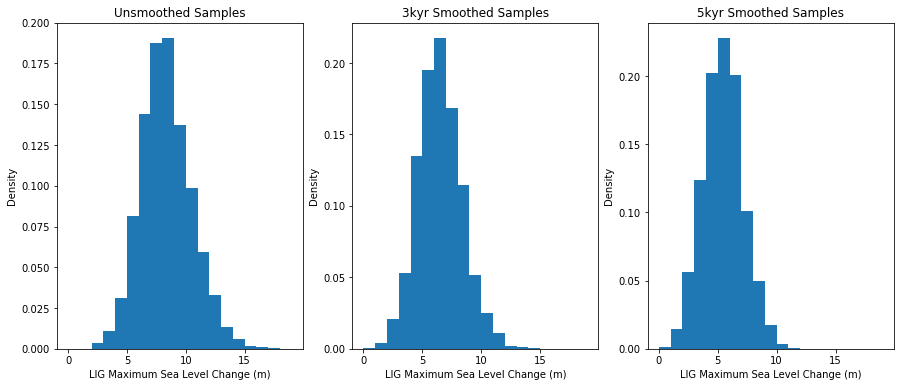

In [52]:
# plot the distributions of the maxes from each timeseries
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
plt.hist(k09_unsmoothed_samps_max,bins=np.arange(20),normed=True)
plt.ylabel('Density')
plt.xlabel('LIG Maximum Sea Level Change (m)')
plt.title('Unsmoothed Samples')

plt.subplot(1, 3, 2)
plt.hist(k09_smoothed3kyr_samps_max,bins=np.arange(20),normed=True)
plt.ylabel('Density')
plt.xlabel('LIG Maximum Sea Level Change (m)')
plt.title('3kyr Smoothed Samples')

plt.subplot(1, 3, 3)
plt.hist(k09_smoothed5kyr_samps_max,bins=np.arange(20),normed=True)
plt.ylabel('Density')
plt.xlabel('LIG Maximum Sea Level Change (m)')
plt.title('5kyr Smoothed Samples')

plt.show()

In [53]:
# fit an empirical distribution to this likelihood
k09_max_unsmoothed_dist=scipy.stats.gaussian_kde(k09_unsmoothed_samps_max)
k09_max_smoothed3kyr_dist=scipy.stats.gaussian_kde(k09_smoothed3kyr_samps_max)
k09_max_smoothed5kyr_dist=scipy.stats.gaussian_kde(k09_smoothed5kyr_samps_max)

# find the posterior given by these likelihoods
k09_max_unsmoothed_posterior=posterior_densities(step_locs,prior_norm,k09_max_unsmoothed_dist)
k09_max_smoothed3kyr_posterior=posterior_densities(step_locs,prior_norm,k09_max_smoothed3kyr_dist)
k09_max_smoothed5kyr_posterior=posterior_densities(step_locs,prior_norm,k09_max_smoothed5kyr_dist)

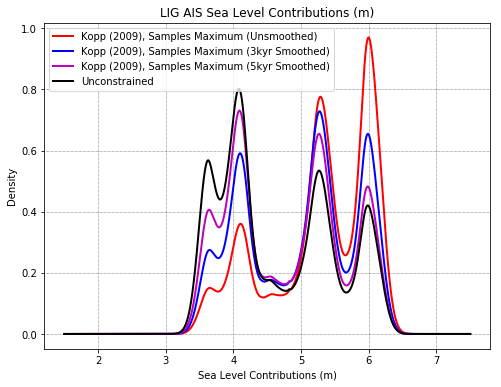

In [54]:
# plot the result for the normalized posterior sea levels
k09_GP_ligpost_max_fig=plt.figure(figsize=(8,6))
plt.plot(step_locs,k09_max_unsmoothed_posterior['posterior'],'r',lw=2,label='Kopp (2009), Samples Maximum (Unsmoothed)')
plt.plot(step_locs,k09_max_smoothed3kyr_posterior['posterior'],'b',lw=2,label='Kopp (2009), Samples Maximum (3kyr Smoothed)')
plt.plot(step_locs,k09_max_smoothed5kyr_posterior['posterior'],'m',lw=2,label='Kopp (2009), Samples Maximum (5kyr Smoothed)')
plt.plot(step_locs,prior_dist['posterior'],'k',lw=2,label='Unconstrained')
plt.title('LIG AIS Sea Level Contributions (m)')
plt.xlabel('Sea Level Contributions (m)')
plt.ylabel('Density')
plt.grid()
plt.legend(loc='best')
plt.show()

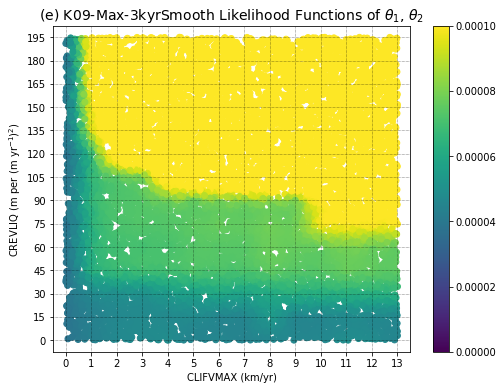

In [55]:
# plot the result for the normalized posterior sea levels
cc_k09_GP_max_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=k09_max_smoothed3kyr_posterior['param_density'],edgecolors='face',vmin=scatter_levels[0],vmax=scatter_levels[1],rasterized=True)
plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title(r'(e) K09-Max-3kyrSmooth Likelihood Functions of $\theta_1$, $\theta_2$',fontsize=14)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

In [56]:
# save the plot out
savename='FigS5e.pdf'
cc_k09_GP_max_fig.savefig(save_path+savename)

## Plot all Specific LIG Constraints

To visualize each of the above constraints relative to the prior, we plot them all together here.

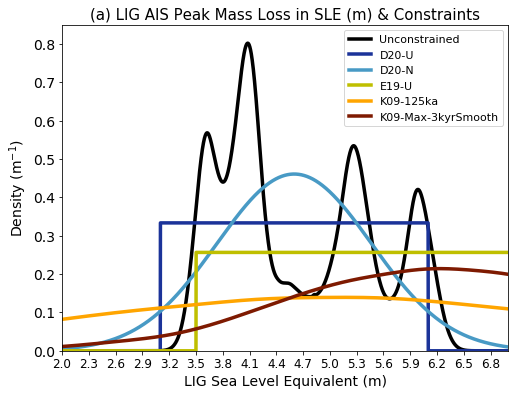

In [57]:
# plot the result for the normalized posterior sea levels vs. each constraintt
constraints_lig_fig=plt.figure(figsize=(8,6))

# prior
plt.plot(step_locs,prior_dist['posterior'],'k',lw=3.5,label='Unconstrained')
# D20 Uniform
plt.plot(step_locs,deconto19_uniform_dist.pdf(step_locs),color=cols[0,:],lw=3.5,label='D20-U')
# D20 Gaussian
plt.plot(step_locs,deconto_gauss_dist.pdf(step_locs),color=cols[1,:],lw=3.5,label='D20-N')
# D20 Uniform Reduced
#plt.plot(step_locs,deconto19_reduced_dist.pdf(step_locs),color=cols[2,:],lw=2,label='D20-33% Red.')
# Edwards et al. (2019) Uniform
plt.plot(step_locs,edwards19_dist.pdf(step_locs),color='y',lw=3.5,label='E19-U')
# Kopp et al. (2009) at 125kya
plt.plot(step_locs,k09_125_dist.pdf(step_locs),color='orange',lw=3.5,label='K09-125ka')
# Kopp et al. (2009), Maximum with 3kyr smoothing
plt.plot(step_locs,k09_max_smoothed3kyr_dist.pdf(step_locs),color=cols[4,:],lw=3.5,label='K09-Max-3kyrSmooth')

plt.xlim([2,7])
plt.xticks(np.arange(2,7,0.1)[::3],fontsize=12)
plt.yticks(fontsize=14)
plt.ylim([0,0.85])
plt.title('(a) LIG AIS Peak Mass Loss in SLE (m) & Constraints',fontsize=15)
plt.xlabel('LIG Sea Level Equivalent (m)',fontsize=14)
plt.ylabel('Density (m$^{-1}$)',fontsize=14)
plt.legend(loc='best',fontsize=11)
plt.show()

In [58]:
# save the plot out
savename='Fig4a.pdf'
constraints_lig_fig.savefig(save_path+savename)

## Conditional Probability Constraints

In this section, we develop an idealized experiment, where we explore what the implications of knowing precisely (within +/- 5 cm) what the LIG constraints are would imply about the likelihoods of CREVLIQ and CLIFVMAX.

In **sample_rcp_emulator.ipynb** we use these likelihoods to see what they would imply about the conditional distributions of future ice-sheet contributions. There we explore RCP8.5 contributions from the Antarctic ice-sheet as a function of (conditional on) LIG contributions.

### 10-cm window Sampling

We define a series of narrow uniform distributions that describe an LIG estimate which is assumed to be known to within +/5 cm, in order to explore how such an estimate would inform RCP8.5 projections.

In [59]:
# define the idealized LIG uniform distributions
idealized_step=0.10
idealized_lb,idealized_ub=2,7
idealized_range=[idealized_lb-idealized_step/2,idealized_ub+idealized_step/2]
idealized_steps=np.arange(idealized_range[0],idealized_range[-1]+idealized_step,idealized_step,dtype='float')
idealized_mid=idealized_steps[:-1]+idealized_step/2
idealized_N=len(idealized_mid)
print(idealized_steps)
print(idealized_mid)
print(idealized_N)

[ 1.95  2.05  2.15  2.25  2.35  2.45  2.55  2.65  2.75  2.85  2.95  3.05
  3.15  3.25  3.35  3.45  3.55  3.65  3.75  3.85  3.95  4.05  4.15  4.25
  4.35  4.45  4.55  4.65  4.75  4.85  4.95  5.05  5.15  5.25  5.35  5.45
  5.55  5.65  5.75  5.85  5.95  6.05  6.15  6.25  6.35  6.45  6.55  6.65
  6.75  6.85  6.95  7.05]
[ 2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4
  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9
  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4
  6.5  6.6  6.7  6.8  6.9  7. ]
51


In [60]:
# loop over each of the individual 10cm buckets to find the CREVLIQ/CLIFMVMAX likelihoods and LIG posteriors
for u in range(idealized_N):
    
    # define the conditional probability distribution in this step
    idealized_dist=uniform(loc=idealized_steps[u], scale=idealized_steps[u+1]-idealized_steps[u]-1e-16)
    
    # find the posterior
    idealized_posterior=posterior_densities(step_locs,prior_norm,idealized_dist)
    
    # initialize or fill the output dictionary
    if u==0:
        lig_posteriors = {u: idealized_posterior}
    else:
        lig_posteriors.update({u: idealized_posterior})
    
    # delete things before starting a new loop
    del idealized_dist, idealized_posterior

### Calculate and plot the Marginal CREVLIQ/CLIFVMAX PDFs

We now calculate and plot the marginal distributions of CREVLIQ and CLIFVMAX directly as a function of the LIG AIS contributions to sea-level change. i.e., we seek to answer, "what are the emulated probabilities of a specific CREVLIQ or CLIFVMAX value, given we knew a specific (very narrow) value of LIG contributions from the AIS?"

In [61]:
# set the step for the CREVLIQ/CLIFVMAX integration and 
# create the integration bins array across uniform parameter values
c_step=1e-2
cc_step_locs=np.arange(0.0,1.0+c_step,step=c_step)
print(cc_step_locs)

[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99  1.  ]


In [62]:
# Create the necessary arrays to store the probabilities (linked to the lhd[:,0] and lhd[:,1] samples, respectively)
crevliq_prob_bins=np.zeros((len(lig_posteriors),len(cc_step_locs)),dtype='float')
clifvmax_prob_bins=np.zeros((len(lig_posteriors),len(cc_step_locs)),dtype='float')

# loop over all the bins to determine the probabilities
for c in range(len(cc_step_locs)):
    
    # find the bounds around the bins
    c_range=[cc_step_locs[c]-c_step,cc_step_locs[c]+c_step]
    
    # find samples indices greater than or equal to the lower bound, less than the upper bound
    crevliq_ind_in_bins=(lhd[:,0]>=c_range[0]) & (lhd[:,0]<c_range[1])
    clifvmax_ind_in_bins=(lhd[:,1]>=c_range[0]) & (lhd[:,1]<c_range[1])
    
    # code to check that the LHC design is uniformly distributed and we grabbing it correctly
    #print(np.sum(c_ind_in_bins))
    #plt.scatter(lhd[c_ind_in_bins,0],lhd[c_ind_in_bins,1])
    
    # find the probability in that bin
    for b in range(len(lig_posteriors)):
        crevliq_prob_bins[b,c]=np.sum(lig_posteriors[b]['param_density'][crevliq_ind_in_bins])
        clifvmax_prob_bins[b,c]=np.sum(lig_posteriors[b]['param_density'][clifvmax_ind_in_bins])
    
    # delete things we don't need until the next loop iteration
    del c_range, crevliq_ind_in_bins, clifvmax_ind_in_bins
    
# noramlize the probabilities
crevliq_prob_norm=crevliq_prob_bins.T/np.sum(crevliq_prob_bins,axis=1)
clifvmax_prob_norm=clifvmax_prob_bins.T/np.sum(clifvmax_prob_bins,axis=1)

In [63]:
# denormalize the CREVLIQ/CLIFVMAX sample grids
denorm_crevliq_step_locs=denormalize(cc_step_locs,np.max(train_dat['crevliq']),np.min(train_dat['crevliq']))
denorm_clifvmax_step_locs=denormalize(cc_step_locs,np.max(train_dat['clifvmax']),np.min(train_dat['clifvmax']))

In [64]:
# color levels necessary for the contouring
clevels=np.linspace(np.log(5e-3),np.log(0.5),11)
clabels=np.round(np.exp(clevels),decimals=3).astype('str')

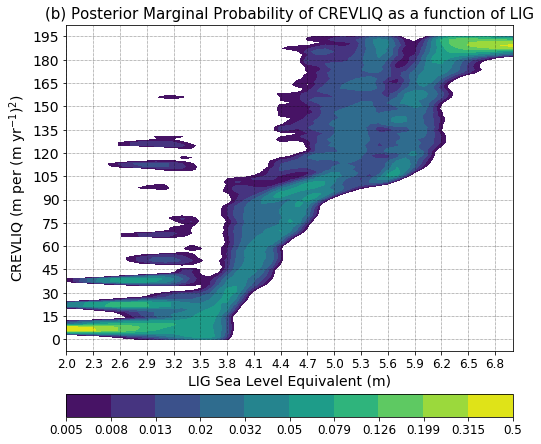

In [65]:
# plot the result for CREVLIQ
crevliq_marginal_fig=plt.figure(figsize=(8,8))
c1=plt.contourf(idealized_mid,denorm_crevliq_step_locs,np.log(crevliq_prob_norm),clevels)
cbar=plt.colorbar(c1,ticks=clevels,orientation='horizontal',pad=0.1)
cbar.set_ticklabels(clabels)
cbar.ax.tick_params(labelsize=12)
plt.xticks(idealized_mid[::3],fontsize=12)
plt.yticks(train_dat['crevliq'],fontsize=14)
plt.ylim([-7.5,202.5])
plt.xlim([2.,7.0])
plt.title('(b) Posterior Marginal Probability of CREVLIQ as a function of LIG',fontsize=15)
plt.xlabel('LIG Sea Level Equivalent (m)',fontsize=14)
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)',fontsize=14)
plt.grid()
plt.show()

In [66]:
# save the plot out
savename='Fig5b.pdf'
crevliq_marginal_fig.savefig(save_path+savename)

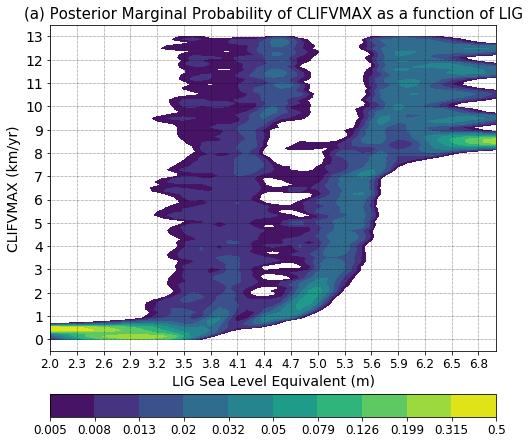

In [67]:
# plot the result for CLIFVMAX
clifvmax_marginal_fig=plt.figure(figsize=(8,8))
c1=plt.contourf(idealized_mid,denorm_clifvmax_step_locs,np.log(clifvmax_prob_norm),clevels)
cbar=plt.colorbar(c1,ticks=clevels,orientation='horizontal',pad=0.1)
cbar.set_ticklabels(clabels)
cbar.ax.tick_params(labelsize=12)
plt.xticks(idealized_mid[::3],fontsize=12)
plt.yticks(train_dat['clifvmax'],fontsize=14)
plt.ylim([-0.5,13.5])
plt.xlim([2.,7.0])
plt.title('(a) Posterior Marginal Probability of CLIFVMAX as a function of LIG',fontsize=15)
plt.xlabel('LIG Sea Level Equivalent (m)',fontsize=14)
plt.ylabel('CLIFVMAX (km/yr)',fontsize=14)
plt.grid()
plt.show()

In [68]:
# save the plot out
savename='Fig5a.pdf'
clifvmax_marginal_fig.savefig(save_path+savename)

# Store/Save the Results

### Save specific distribution arrays:

With each of the above CREVLIQ/CLIFVMAX posteriors found (as conditioned on the LIG constraints), we save them out to be used as priors for the sampling in **sample_rcp_emulator.ipynb**.

In [69]:
# create the dictionary with CREVLIQ/CLIFVMAX priors
cc_likelihoods={'equal': np.squeeze(equal_density.T), \
           'D20_U': deconto19_uniform['param_density'], \
           'D20_N': deconto19_gaussian['param_density'], \
           'e19_U': edwards19_uniform['param_density'], \
           'k09_125': k09_125_posterior['param_density'], \
           'k09_max_1kyr': k09_max_unsmoothed_posterior['param_density'], \
           'k09_max_3kyr': k09_max_smoothed3kyr_posterior['param_density'], \
           'k09_max_5kyr': k09_max_smoothed5kyr_posterior['param_density'], \
           
           'high_U': high_uniform['param_density'], \
           'low_U': low_uniform['param_density'], \
           
           'range_90': range90_uniform['param_density'], \
           'range_75': range75_uniform['param_density'], \
           'range_50': range50_uniform['param_density'], \
           'range_25': range25_uniform['param_density'], \
           'range_10': range10_uniform['param_density'] \
          }

# save the dictionary
pickle.dump(cc_likelihoods, open( "./models/cc_likelihoods.pk1", "wb" ) )

### Get the Idealized Mid weightings

Unconstrained weighting used to create Figure 8 in **visualize_lig_error_importance.ipynb**.

### Save conditional probability distribution arrays:

In [70]:
# estimate the prior PDF from the LHC samples for the LIG at the idealized_mid_steps locations for integration
prior_idealized_dist_lig=posterior_densities(idealized_mid,prior_norm,0)

In [71]:
# store the idealized array
idealized_dat={'lig_posteriors': lig_posteriors, 'idealized_mid_steps': idealized_mid, 'ligmid_weightings': prior_idealized_dist_lig}

# save the dictionary
pickle.dump(idealized_dat, open( "./models/lig_posteriors.pk1", "wb" ) )